In [24]:
# !pip install tensorflow-macos==2.10.0

  Using cached tensorflow_macos-2.10.0-cp310-cp310-macosx_12_0_arm64.whl (211.5 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.8.0-cp310-cp310-macosx_11_0_arm64.whl (2.6 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 34.2 MB/s eta 0:00:0000:0100:01
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached protobuf-3.19.6-py2.py3-none-any.whl (162 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 36.5 MB/s eta 0:00:0000:0100:01
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached wheel-0.40.0-py3-none-any.whl (64 kB)
     ━━━

In [106]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow import image
from sklearn.preprocessing import LabelBinarizer

import tensorflowjs as tfjs

## Data Load

In [124]:
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 
            'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 
            'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [127]:
df_test = pd.read_csv("../raw_data/archive/sign_mnist_test/sign_mnist_test.csv")
df_train = pd.read_csv("../raw_data/archive/sign_mnist_train/sign_mnist_train.csv")
df_train['label'] = df_train['label'].apply(lambda x: alphabet[x])
df_test['label'] = df_test['label'].apply(lambda x: alphabet[x])
df_test = df_test.drop(['label'], axis=1)
df_test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


In [128]:
df_train['label'].nunique()

24

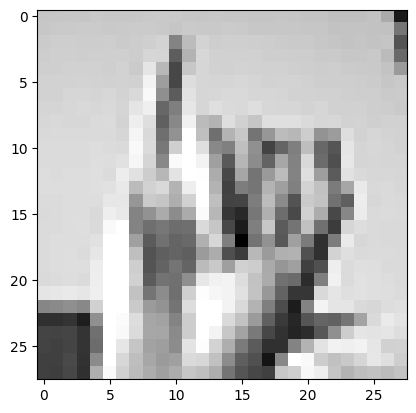

In [129]:
plt.imshow(df_test.iloc[10].values.reshape(28, -1), cmap='gray')

## Model Creation

In [130]:
model = models.Sequential()

# model.add(layers.Lambda(lambda x: image.resize(x, (28,28)),input_shape=(28,28,3)))
# model.add(layers.Lambda(lambda x: image.rgb_to_grayscale(x)))

model.add(layers.Conv2D(6, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
model.add(layers.Flatten())
model.add(layers.Dense(24, activation='softmax'))


In [131]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [132]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 26, 26, 6)         60        
                                                                 
 flatten_13 (Flatten)        (None, 4056)              0         
                                                                 
 dense_13 (Dense)            (None, 24)                97368     
                                                                 
Total params: 97,428
Trainable params: 97,428
Non-trainable params: 0
_________________________________________________________________


In [133]:
X_train_raw = df_train.drop(['label'], axis=1)
X_train = []
for i, row in X_train_raw.iterrows():
    X_train.append(np.array([row]).reshape(28, 28, 1))

X_train = np.array(X_train)    
y_train = np.array(df_train['label']).reshape(-1, 1)
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)

In [135]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
858/858 [==============================] - 2s 2ms/step - loss: 29.5325
Epoch 2/5
858/858 [==============================] - 2s 2ms/step - loss: 0.1024
Epoch 3/5
858/858 [==============================] - 2s 2ms/step - loss: 0.0258
Epoch 4/5
858/858 [==============================] - 2s 2ms/step - loss: 0.0151
Epoch 5/5
858/858 [==============================] - 2s 2ms/step - loss: 0.0184


In [137]:
models.save_model(model, 'saved_model.h5')

In [96]:
for node in model.outputs:
    print(node.name)

dense_1/Softmax:0


In [142]:
tfjs.converters.save_keras_model(model, '../../cam-app/saved_model/', metadata={'labels': list(lb.classes_)})